In [1]:
!nvidia-smi

Thu May 23 05:07:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import auth
import os

from google.colab import drive
auth.authenticate_user()

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
os.chdir('gdrive/MyDrive/DataScience/Datasets/CSE555/EEG')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import datetime
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [ ]:
# os.chdir('/projects/academic/courses/cse676s24/dsingh27/cse555/datasets/preprocessed/')

In [5]:
dfBinauraluser4 = pd.read_csv('preprocessed_1004_2.csv')

In [6]:
dfBinauraluser3 = pd.read_csv('preprocessed_1003_2.csv')

In [7]:
dfBinauraluser4.columns

Index(['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7',
       'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2',
       'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'VEO+',
       'VEO-', 'HEOL', 'HEOR', 'FCz', 'Iz', 'B9', 'B10', 'Time'],
      dtype='object')

In [8]:
dfBinauraluser4 = dfBinauraluser4[['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7',
       'P3', 'Pz', 'PO3', 'O1', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2',
       'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'
       , 'Iz']]

In [9]:
dfBinauraluser3 = dfBinauraluser3[['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7',
       'P3', 'Pz', 'PO3', 'O1', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2',
       'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'
       , 'Iz']]

In [10]:
dfBinauraluser3Copy = dfBinauraluser3
dfBinauraluser4Copy = dfBinauraluser4

# Making the time series stationary

In [11]:
dfBinauraluser3FirstDiff = dfBinauraluser3Copy.diff()[1:]
dfBinauraluser4FirstDiff = dfBinauraluser4Copy.diff()[1:]

# Normalization

In [12]:
def min_max_normalize_data(df):
    """
    Applies Min-Max normalization to each column (feature) independently.

    Args:
    df (DataFrame): The DataFrame containing EEG data.

    Returns:
    DataFrame: A DataFrame with Min-Max normalized data for each column.
    """
    return (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))


# Epoch generation pipeline

In [2]:
def create_epochs_correctly(df, epoch_length=64):
    # total number of samples and features
    total_samples, num_features = df.shape

    # Calculate the number of epochs
    num_epochs = total_samples // epoch_length

    epochs = np.zeros((num_epochs, epoch_length, num_features)) #shape order (num_epochs, epoch_length, num_features)

    for i in range(num_epochs):
        epochs[i] = df.iloc[i*epoch_length:(i+1)*epoch_length].values 

    return epochs


In [14]:
dfBinauraluser4Copy = dfBinauraluser4FirstDiff.iloc[-1013760:][:].reset_index(drop=True)
dfBinauraluser3Copy = dfBinauraluser3FirstDiff.iloc[-1013760:][:].reset_index(drop=True)

In [15]:
dfBinauraluser4_normalized = min_max_normalize_data(dfBinauraluser4Copy)
dfBinauraluser3_normalized = min_max_normalize_data(dfBinauraluser3Copy)

In [16]:
dfBinauraluser4_normalized.shape

(1013760, 32)

In [19]:
dfBinauraluser4_epochs = create_epochs_correctly(dfBinauraluser4_normalized)
dfBinauraluser3_epochs = create_epochs_correctly(dfBinauraluser3_normalized)

In [20]:
print(dfBinauraluser4_epochs.shape)
print(dfBinauraluser3_epochs.shape)

(15840, 64, 32)
(15840, 64, 32)


# Label Generating Pipeline

In [21]:
def assign_labels(num_epochs, label):
    return np.full((num_epochs,), label)

labels_binauralUser3 = assign_labels(dfBinauraluser3_epochs.shape[0], 1)
labels_binauralUser4 = assign_labels(dfBinauraluser4_epochs.shape[0], 0)


In [22]:
labels_binauralUser3.shape

(15840,)

# Data shuffling pipeline

In [23]:
np.random.seed(42)

data = np.concatenate((dfBinauraluser3_epochs, dfBinauraluser4_epochs), axis=0)
labels = np.concatenate((labels_binauralUser3, labels_binauralUser4), axis=0)

# Combine into a single dataset (optional: shuffle here)
def shuffle_data(data, labels):
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    return data[indices], labels[indices]

data_shuffled, labels_shuffled = shuffle_data(data, labels)

In [ ]:
# data_shuffled, labels_shuffled = data, labels

# Data Generation Pipeline

In [24]:
import numpy as np
import tensorflow as tf

# Define the sizes for split
total_samples = data_shuffled.shape[0]
train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size 

# Split the data into training, validation, and test sets
train_data = data_shuffled[:train_size]
train_labels = labels_shuffled[:train_size]

val_data = data_shuffled[train_size:train_size + val_size]
val_labels = labels_shuffled[train_size:train_size + val_size]

test_data = data_shuffled[train_size + val_size:]
test_labels = labels_shuffled[train_size + val_size:]

# Define batch size
batch_size = 32  

def create_dataset(data, conditions, batch_size):
    # conditions shaped as (N, 1)
    conditions = np.expand_dims(conditions, axis=1)
    # ((eeg_data, conditions), conditions)
    dataset = tf.data.Dataset.from_tensor_slices(((data, conditions), conditions))
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# split using the correct batch size
train_dataset = create_dataset(train_data, train_labels, batch_size)
val_dataset = create_dataset(val_data, val_labels, batch_size)
test_dataset = create_dataset(test_data, test_labels, batch_size)


for (inputs, conditions), _ in train_dataset.take(1):
    print(f"Input 1 (EEG Data) shape: {inputs.shape}")  # EEG data
    print(f"Input 2 (Conditions) shape: {conditions.shape}") 

Input 1 (EEG Data) shape: (32, 64, 32)
Input 2 (Conditions) shape: (32, 1)


In [25]:
(eeg_inputs, conditions), _ = next(iter(test_dataset.take(1)))

In [26]:
print("Shape of train_labels before dataset creation:", train_labels.shape)

Shape of train_labels before dataset creation: (22176,)


# Model Definition and Learning

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses, backend as K
from tensorflow.keras.optimizers import Adam

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def calculate_upsampling_size(current_size, target_size):
    upsampling_factors = []
    while current_size < target_size:
        current_size *= 2
        upsampling_factors.append(2)
        if current_size > target_size:
            raise ValueError("Cannot upsample to the exact target size. Choose a target size that is a power of 2.")
    return upsampling_factors

def dynamic_decoder(latent_dim, condition_input, target_shape):
    # Start with inputs
    decoder_input = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Concatenate()([decoder_input, condition_input])

    # Initial dense layer
    x = layers.Dense(256, activation='relu')(x)

    # Calculate the upsampling needed
    initial_shape = (target_shape[0] // np.prod(calculate_upsampling_size(1, target_shape[0])), latent_dim)
    x = layers.Dense(np.prod(initial_shape), activation='relu')(x)
    x = layers.Reshape(initial_shape)(x)

    # Add the upsampling and Conv1DTranspose layers dynamically
    for factor in calculate_upsampling_size(initial_shape[0], target_shape[0]):
        x = layers.UpSampling1D(factor)(x)
        x = layers.Conv1DTranspose(target_shape[1], 3, activation='relu', padding='same')(x)

    # Final output layer to match the number of EEG channels and correct temporal dimension
    decoded = layers.Conv1D(target_shape[1], 3, activation='sigmoid', padding='same', name='decoder_output')(x)

    return models.Model(inputs=[decoder_input, condition_input], outputs=decoded, name='decoder')

def create_cvae(input_shape, latent_dim, num_conditions):
    eeg_input = layers.Input(shape=input_shape, name='encoder_input')
    condition_input = layers.Input(shape=(1,), name='condition_input')

    # Encoder
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(eeg_input)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Concatenate()([x, condition_input])
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

    # Decoder
    decoder_input = layers.Input(shape=(latent_dim,), name='z_sampling')
    decoder_cond = layers.Input(shape=(1,), name='decoder_condition')
    x = layers.Concatenate()([decoder_input, decoder_cond])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(np.prod([16, 128]), activation='relu')(x)  # Adjusted based on the last encoder shape
    x = layers.Reshape((16, 128))(x)
    x = layers.Conv1DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # Upsamples to (32, 128)
    x = layers.Conv1DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # Upsamples to (64, 128)
    x = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(x)

    # Final output layer to match the number of EEG channels and correct temporal dimension
    decoded = layers.Conv1D(32, 3, activation='sigmoid', padding='same', name='decoder_output')(x)

    # Models
    encoder = models.Model(inputs=[eeg_input, condition_input], outputs=[z_mean, z_log_var, z], name='encoder')
#     decoder = models.Model(inputs=[decoder_input, decoder_cond], outputs=decoded, name='decoder')
    decoder = dynamic_decoder(latent_dim, condition_input, input_shape)
    vae_output = decoder([encoder([eeg_input, condition_input])[2], condition_input])
    cvae = models.Model(inputs=[eeg_input, condition_input], outputs=vae_output, name='cvae')

    # Loss function
    reconstruction_loss = losses.MeanSquaredError()(eeg_input, vae_output)
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    cvae.add_loss(reconstruction_loss + kl_loss)
    cvae.compile(optimizer=Adam(learning_rate=0.0001))

    return encoder, decoder, cvae


input_shape = (eeg_inputs.shape[1], 32)
latent_dim = 32
num_conditions = 2

encoder, decoder, cvae = create_cvae(input_shape, latent_dim, num_conditions)

# Model Summary
encoder.summary()
decoder.summary()
cvae.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 32)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 64, 32)               3104      ['encoder_input[0][0]']       
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 32, 32)               0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 32, 64)               6208      ['max_pooling1d[0][0]'] 

In [28]:
type(encoder)

keras.src.engine.functional.Functional

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Callbacks for saving the model and early stopping
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model training
history = cvae.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)


Epoch 1/10
693/693 [==============================] - 21s 16ms/step - loss: 0.0029 - val_loss: 5.8966e-04
Epoch 2/10
693/693 [==============================] - 11s 15ms/step - loss: 5.1333e-04 - val_loss: 4.6969e-04
Epoch 3/10
693/693 [==============================] - 10s 14ms/step - loss: 4.4266e-04 - val_loss: 4.2291e-04
Epoch 4/10
693/693 [==============================] - 12s 18ms/step - loss: 4.1187e-04 - val_loss: 4.0551e-04
Epoch 5/10
693/693 [==============================] - 10s 15ms/step - loss: 4.0112e-04 - val_loss: 3.9972e-04
Epoch 6/10
693/693 [==============================] - 10s 14ms/step - loss: 3.9764e-04 - val_loss: 3.9678e-04
Epoch 7/10
693/693 [==============================] - 12s 17ms/step - loss: 3.9496e-04 - val_loss: 3.9511e-04
Epoch 8/10
693/693 [==============================] - 11s 15ms/step - loss: 3.9366e-04 - val_loss: 3.9409e-04
Epoch 9/10
693/693 [==============================] - 11s 15ms/step - loss: 3.9280e-04 - val_loss: 3.9344e-04
Epoch 10/10
69

loop ran for 0 times
first sample input is [[[0.37934238 0.52863265 0.35006974 ... 0.22650057 0.20181311 0.50969529]
  [0.3624739  0.45072069 0.48535565 ... 0.20546837 0.25801953 0.5401662 ]
  [0.36546973 0.40786911 0.58716876 ... 0.20061479 0.29121339 0.59556787]
  ...
  [0.3763048  0.49746786 0.45606695 ... 0.22488271 0.21576011 0.52354571]
  [0.39001044 0.51694585 0.55230126 ... 0.24106132 0.23835425 0.54847645]
  [0.38350731 0.52084145 0.53835425 ... 0.23944346 0.227894   0.53739612]]]
first input shape is (1, 64, 32)
first feature value is first input is [0.37934238 0.3624739  0.36546973 0.37699374 0.3590501  0.37329854
 0.38361169 0.37868476 0.37634656 0.37946764 0.36925887 0.36661795
 0.36978079 0.37509395 0.36520877 0.36675365 0.37810021 0.38057411
 0.36612735 0.35545929 0.38312109 0.39001044 0.36795407 0.36276618
 0.36586639 0.3867119  0.38514614 0.37268267 0.36909186 0.3736952
 0.37017745 0.37496868 0.37659708 0.36912317 0.3717119  0.36915449
 0.37340292 0.3758142  0.37888309

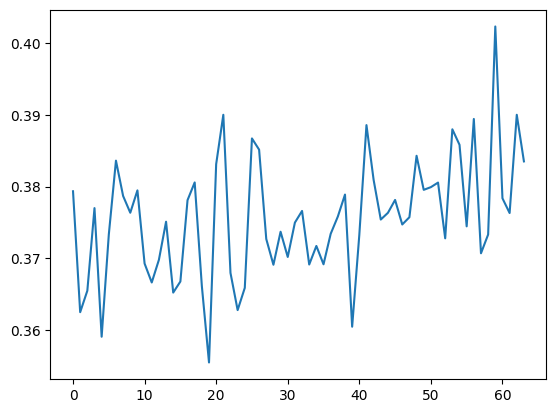

second feature value is first input is [0.52863265 0.45072069 0.40786911 0.49746786 0.49357226 0.49746786
 0.51305025 0.49746786 0.49357226 0.50136346 0.50136346 0.48188547
 0.50136346 0.51694585 0.43903389 0.4234515  0.52084145 0.55200623
 0.51305025 0.40397351 0.47409427 0.54811063 0.50525906 0.47409427
 0.45461628 0.54031944 0.53252824 0.45851188 0.47409427 0.51694585
 0.48578107 0.47409427 0.51305025 0.46240748 0.47798987 0.48188547
 0.51305025 0.53252824 0.51694585 0.4156603  0.47019868 0.54811063
 0.47798987 0.48188547 0.50525906 0.52084145 0.52084145 0.48578107
 0.45461628 0.50136346 0.50525906 0.52084145 0.49357226 0.52473705
 0.52473705 0.49357226 0.54811063 0.45461628 0.44682509 0.56758862
 0.50915466 0.49746786 0.51694585 0.52084145]


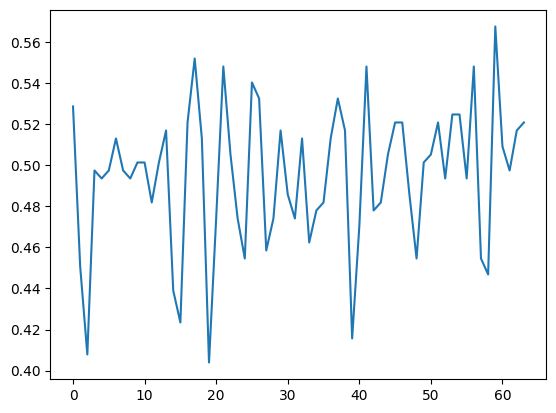

1/1 [==============================] - 1s 757ms/step
predicted Output shape is (1, 64, 32)
predicted_output shape after squeeze is (64, 32)


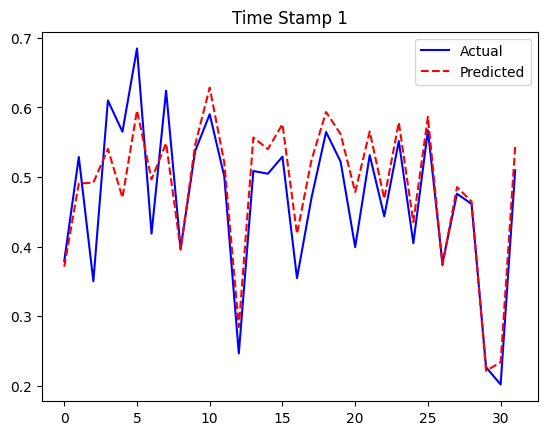

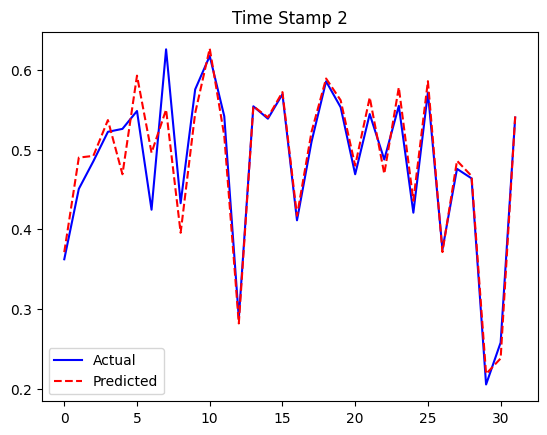

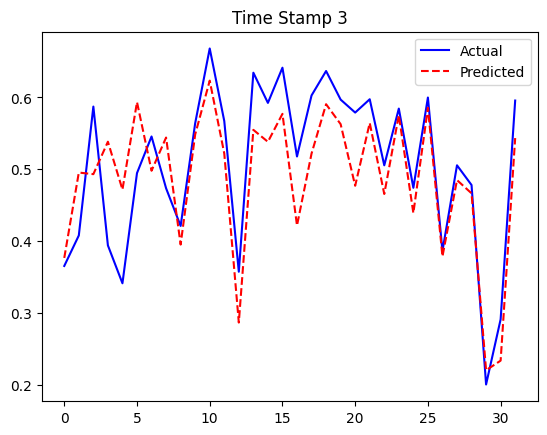

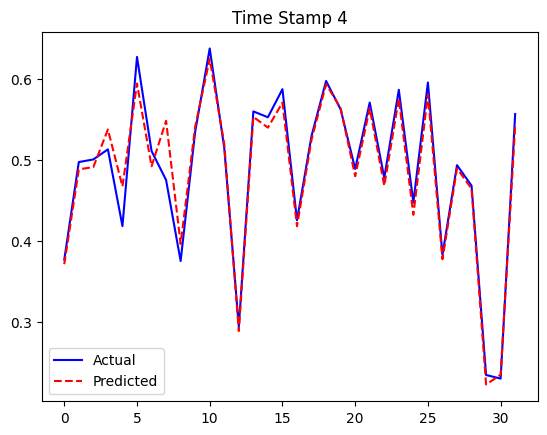

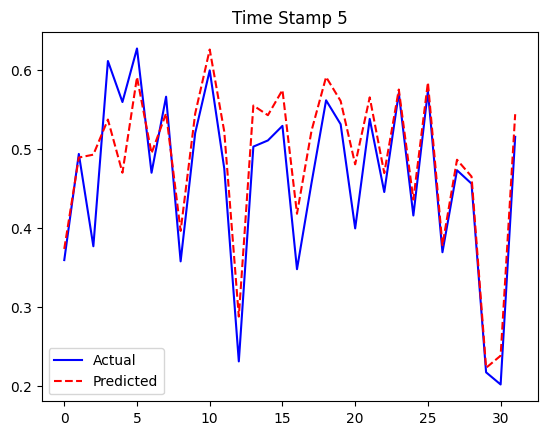

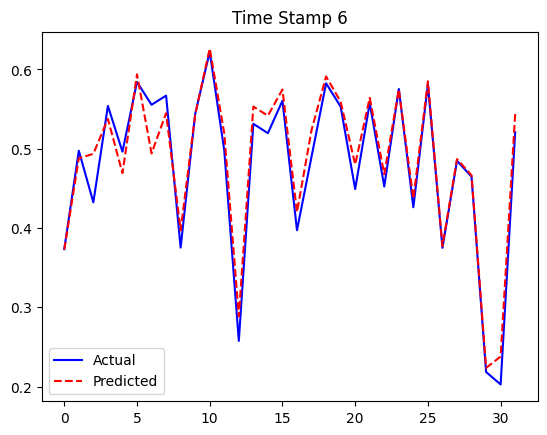

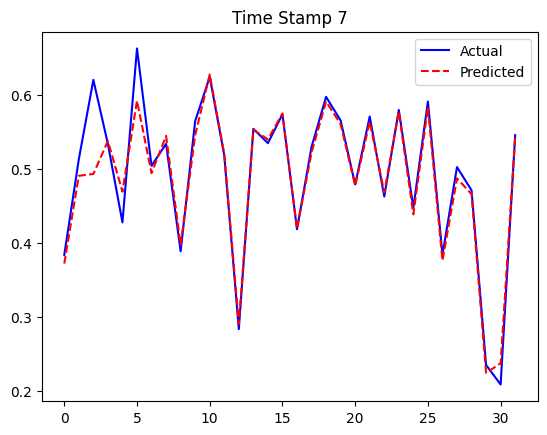

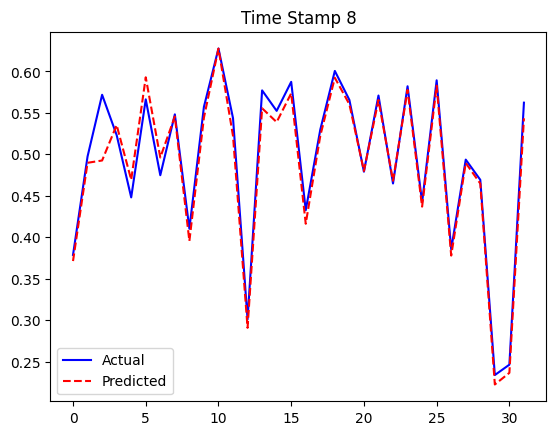

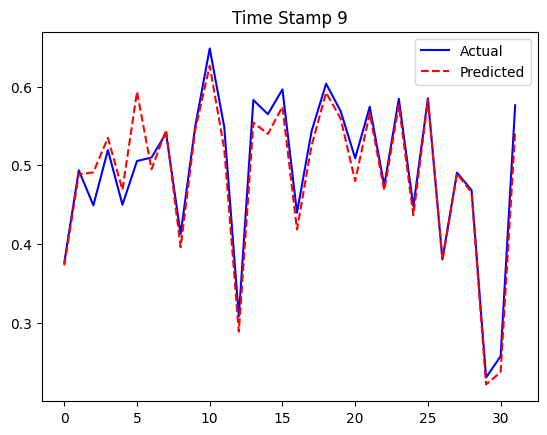

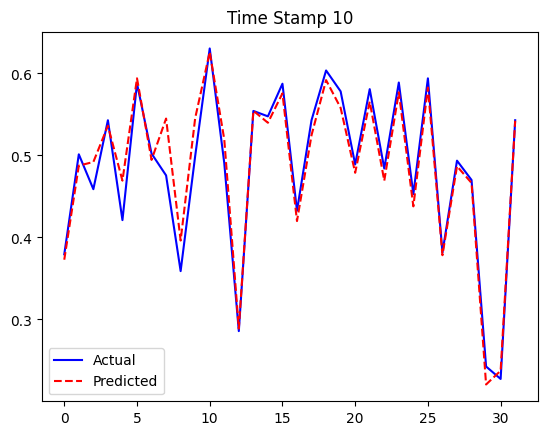

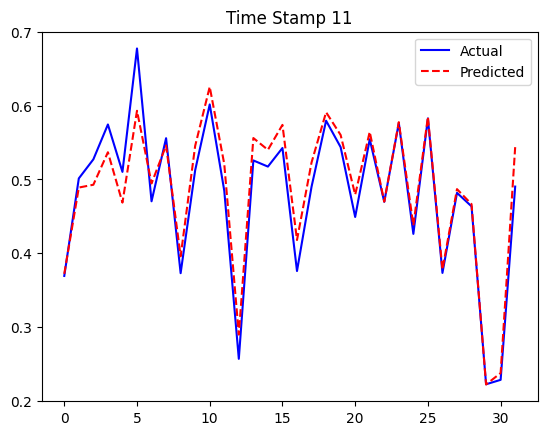

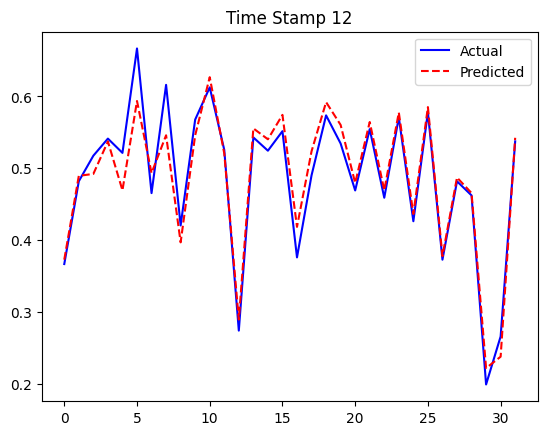

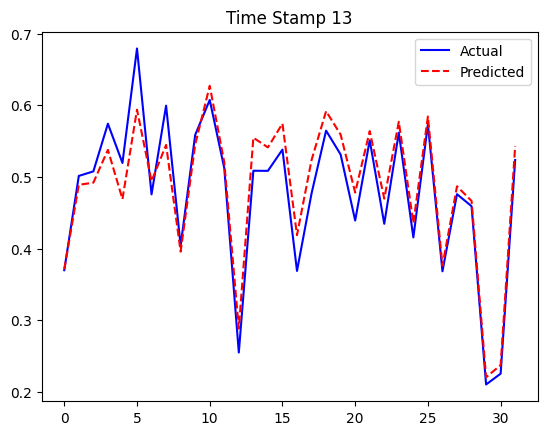

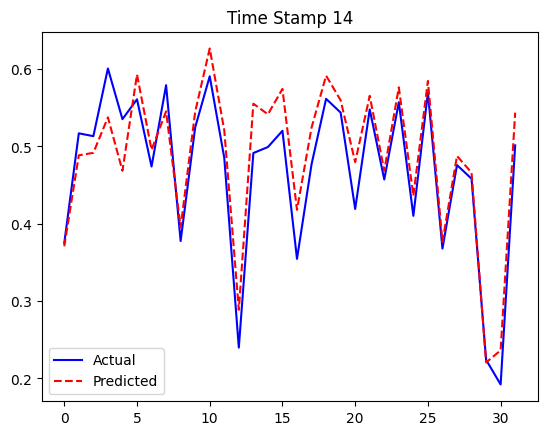

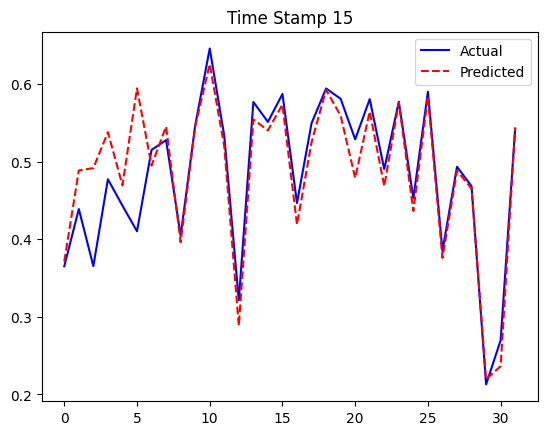

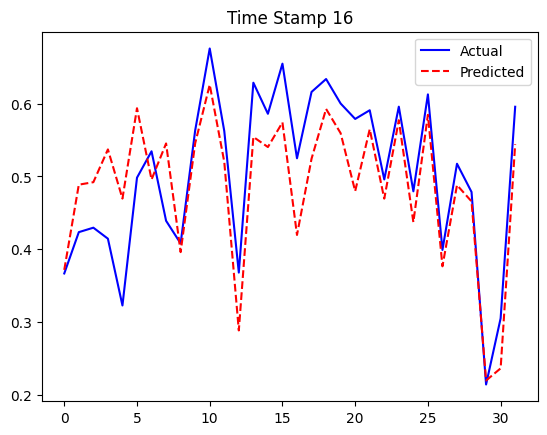

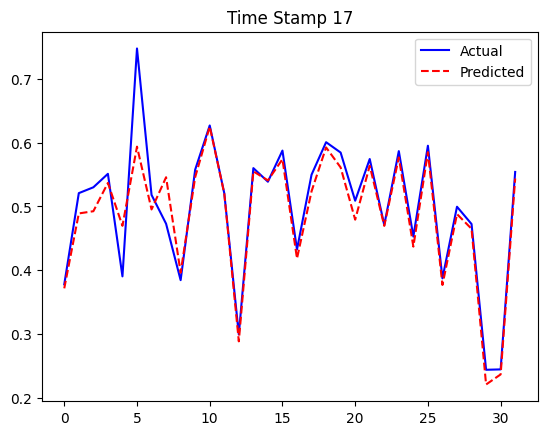

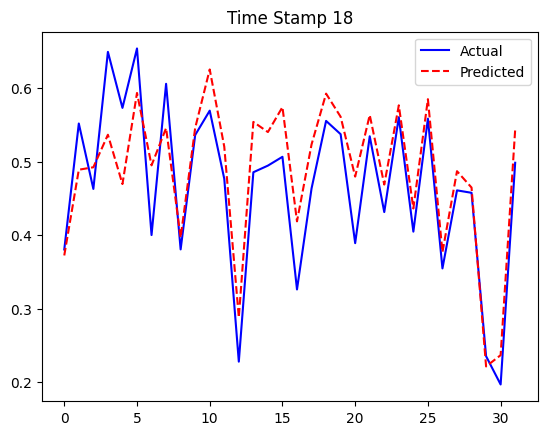

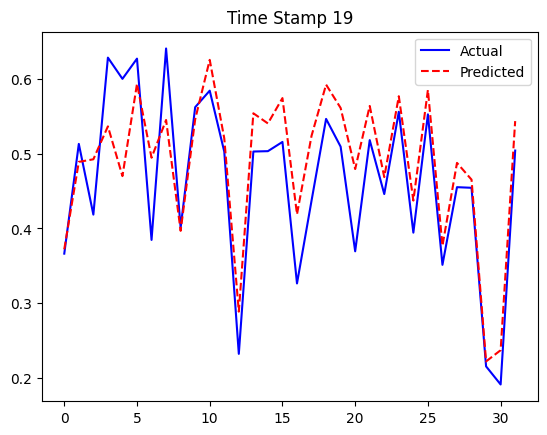

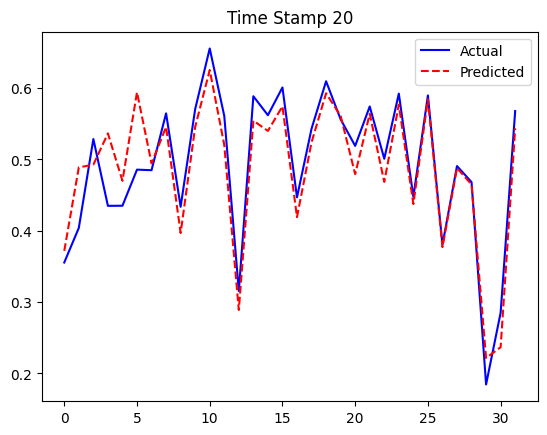

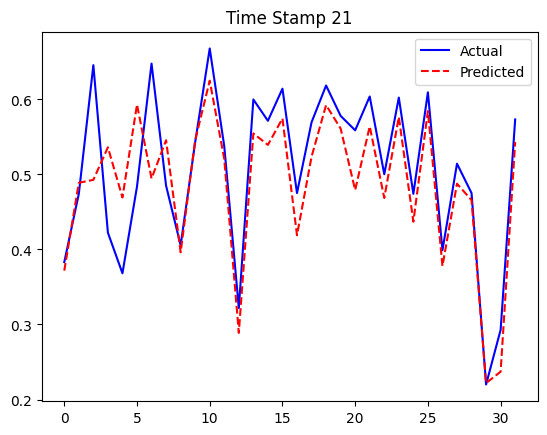

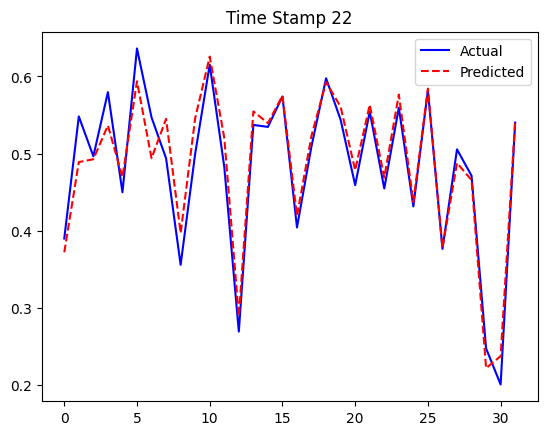

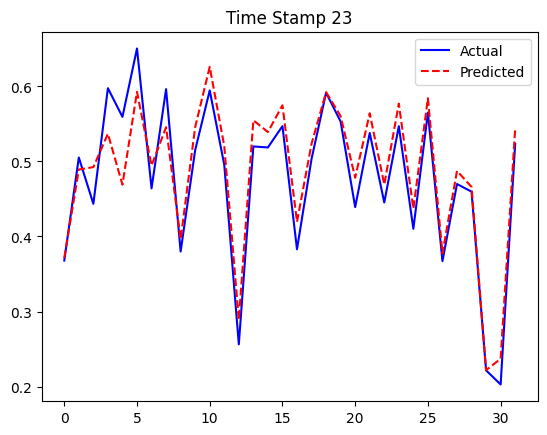

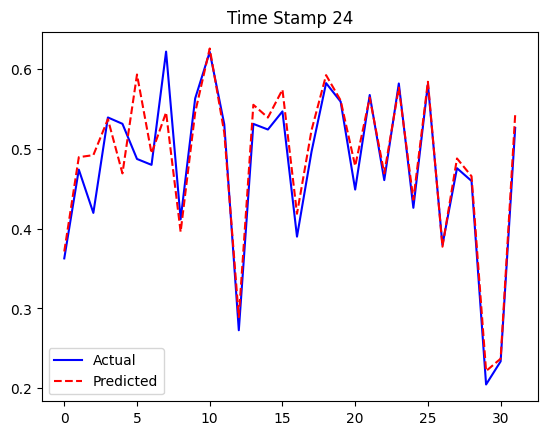

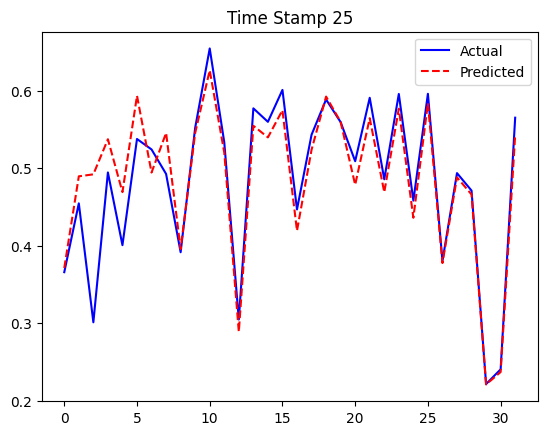

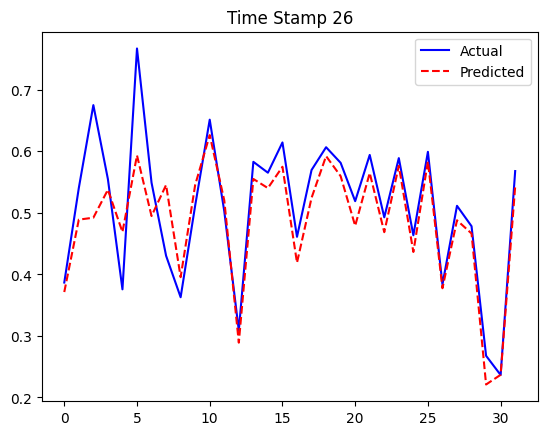

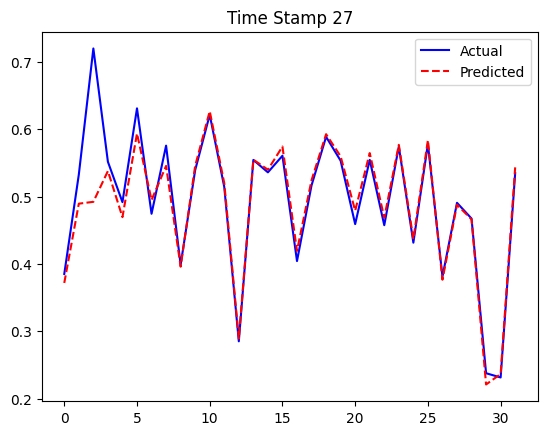

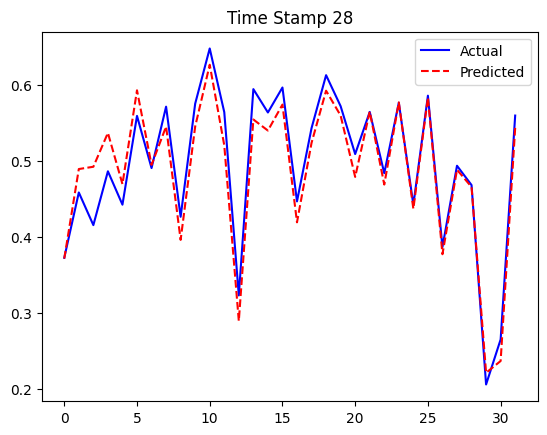

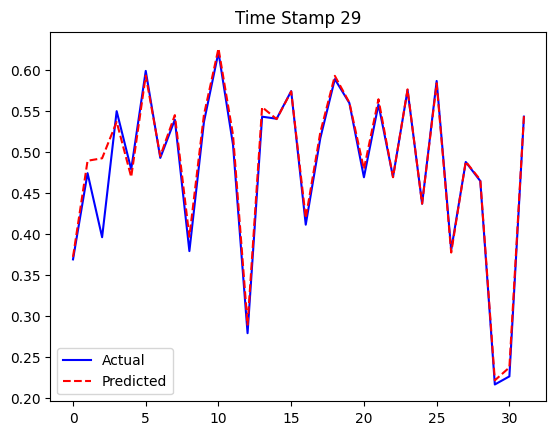

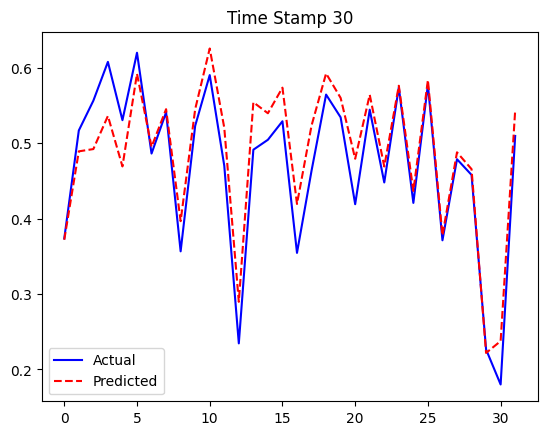

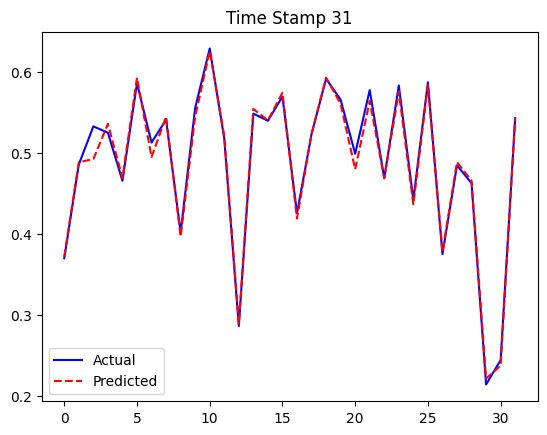

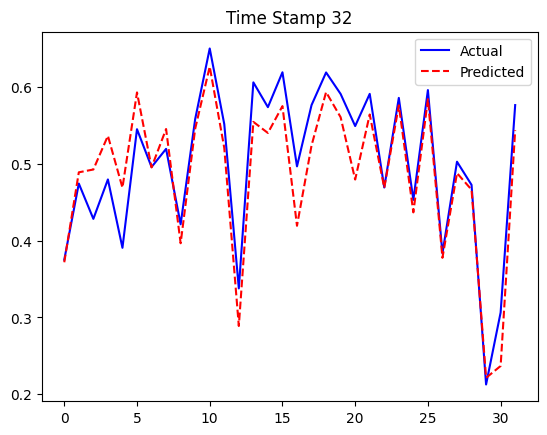

In [30]:
import matplotlib.pyplot as plt

def plot_feature_comparisons(original, prediction, feature_count=32):
#     fig, axes = plt.subplots(feature_count, 1, figsize=(10, 2*feature_count))
    for i in range(feature_count):
        plt.plot(original[i], 'b-', label='Actual')
        plt.plot(prediction[i], 'r--', label='Predicted')
        plt.title(f'Time Stamp {i+1}')
        plt.legend()
#         plt.tight_layout()
        plt.show()

i = 0
# Extract only one batch from the test dataset
for (eeg_inputs, conditions), _ in test_dataset.take(1):
    print(f'loop ran for {i} times')
    i += 1

    first_sample_input = eeg_inputs[0:1]
    print(f'first sample input is {first_sample_input}')
    print(f'first input shape is {first_sample_input.shape}')
    print(f'first feature value is first input is {first_sample_input[0, :, 0]}')
    plt.plot(first_sample_input[0, :, 0])
    plt.show()
    print(f'second feature value is first input is {first_sample_input[0, :, 1]}')
    plt.plot(first_sample_input[0, :, 1])
    plt.show()
    first_sample_condition = conditions[0:1]

    # Predict the output using the cvae model
    predicted_output = cvae.predict([first_sample_input, first_sample_condition])
    print(f'predicted Output shape is {predicted_output.shape}')

    first_sample_input = first_sample_input.numpy().squeeze()
    predicted_output = predicted_output.squeeze()
    print(f'predicted_output shape after squeeze is {predicted_output.shape}')
    # Plot the comparison
    plot_feature_comparisons(first_sample_input, predicted_output)




Condition is [[0]]
1/1 [==============================] - 0s 20ms/step


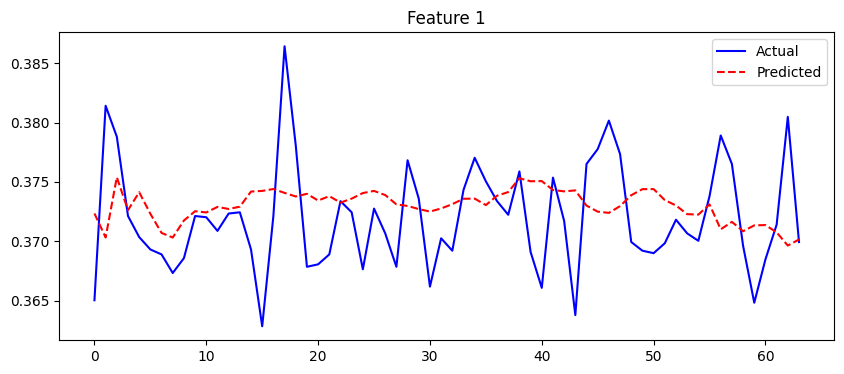

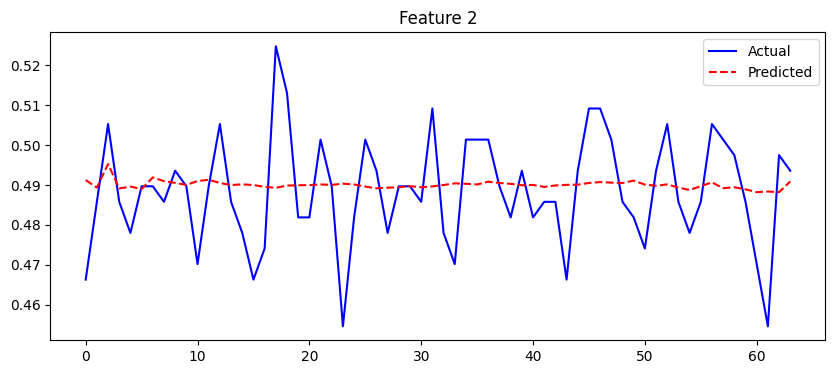

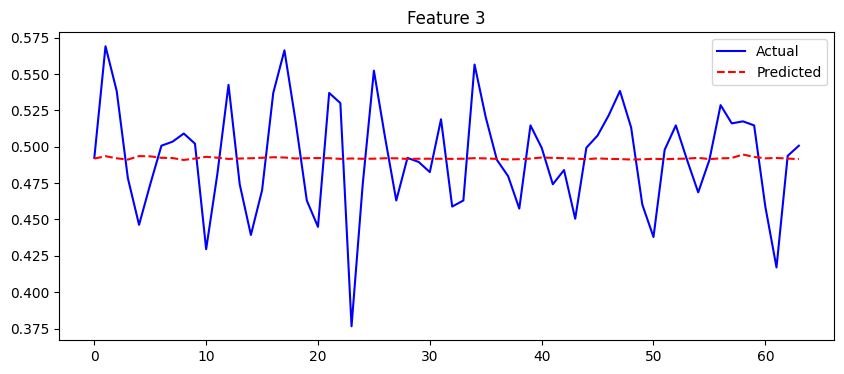

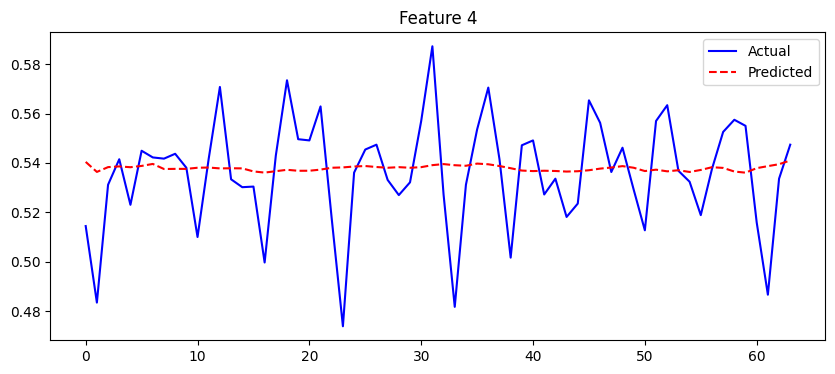

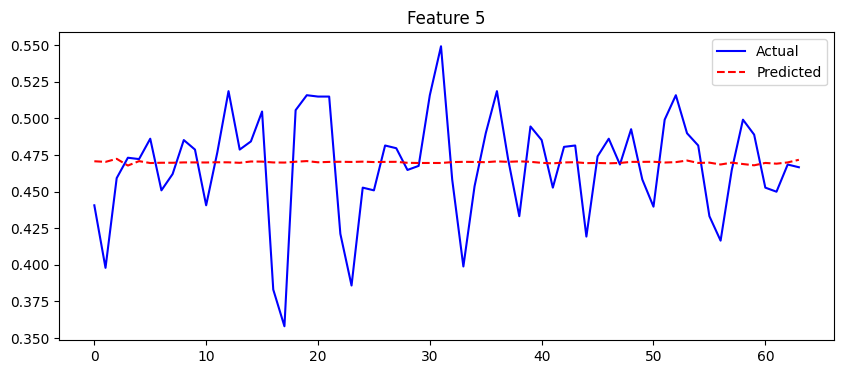

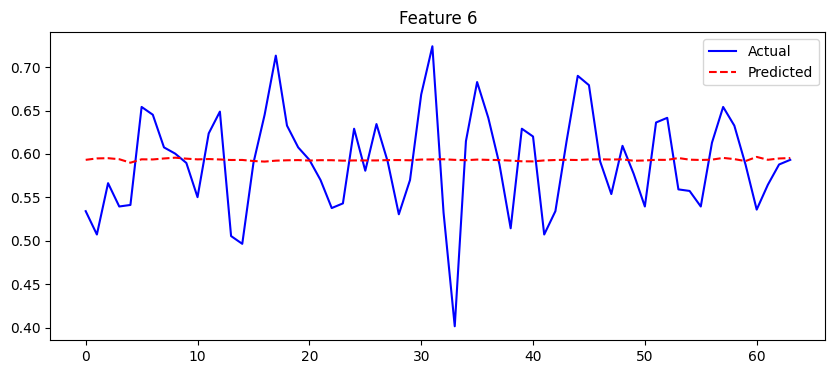

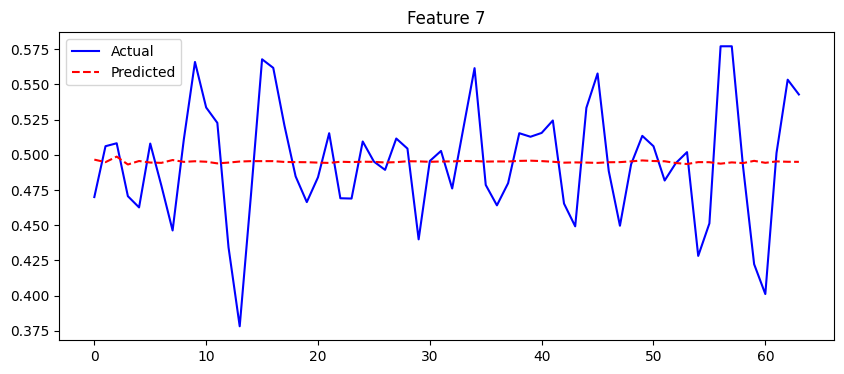

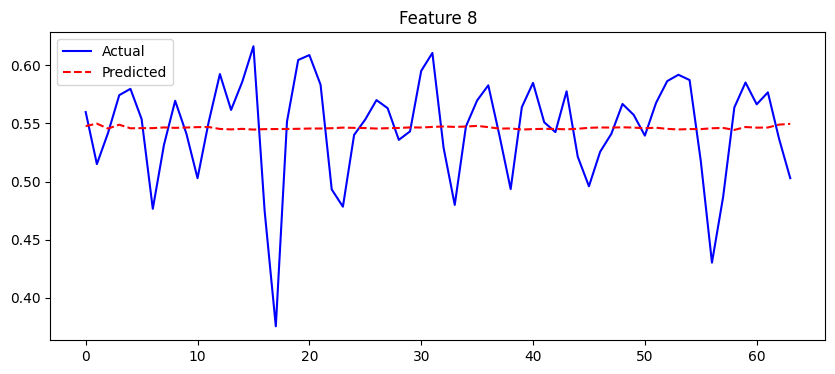

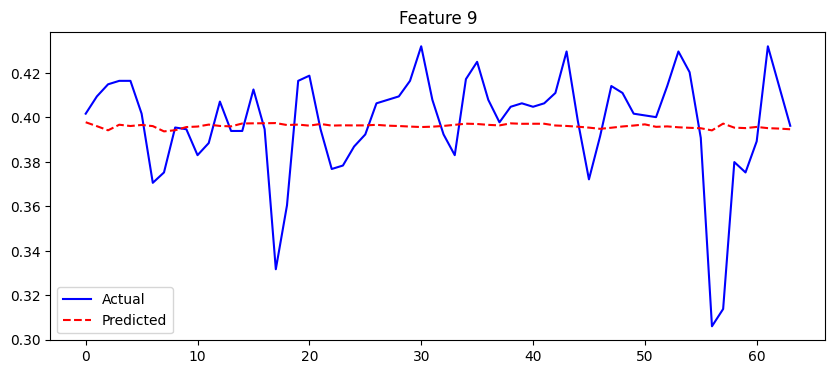

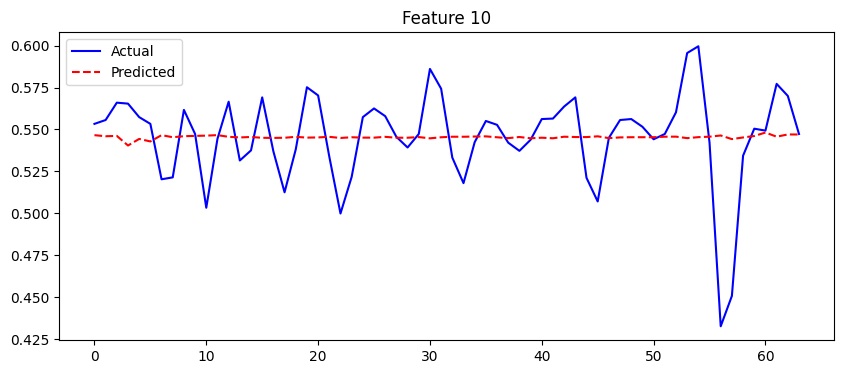

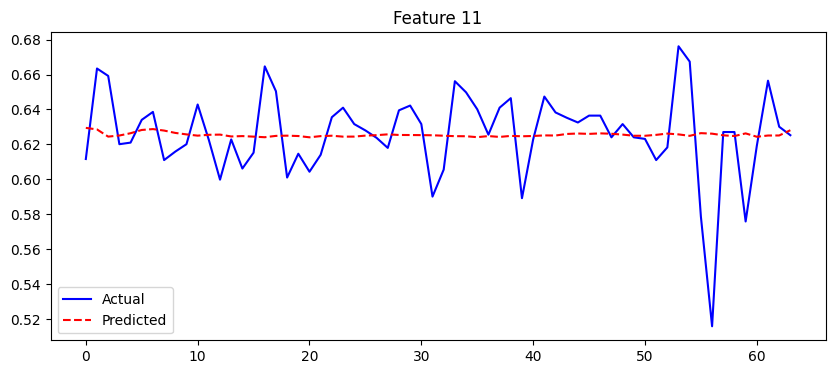

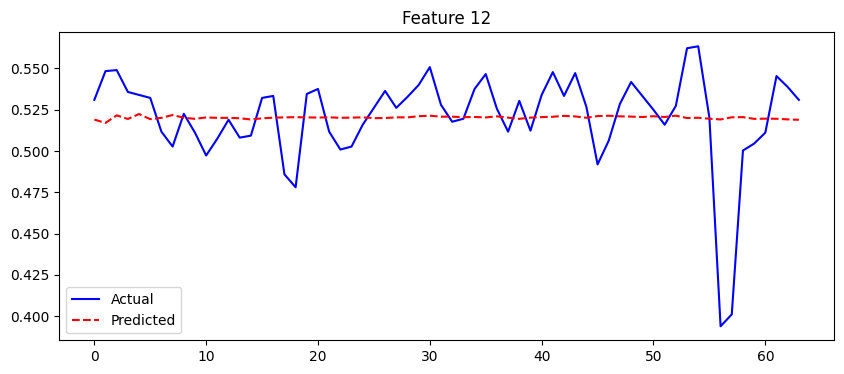

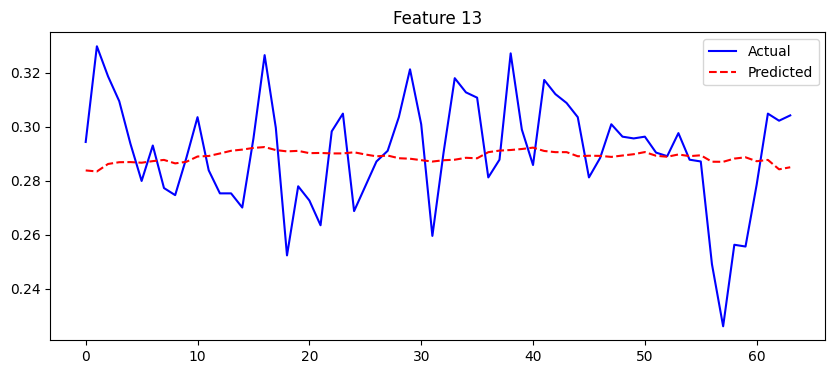

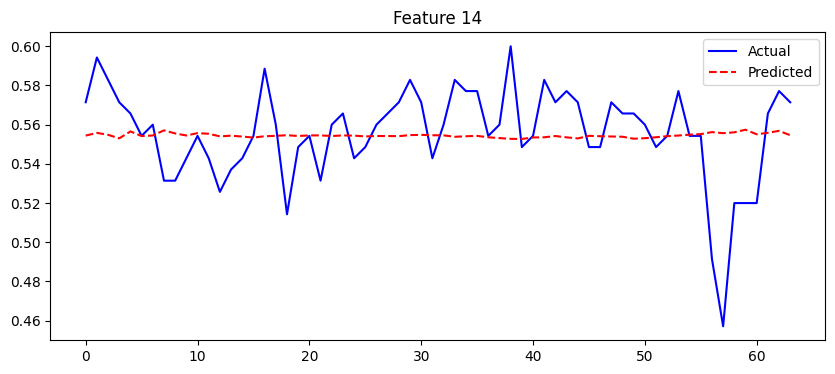

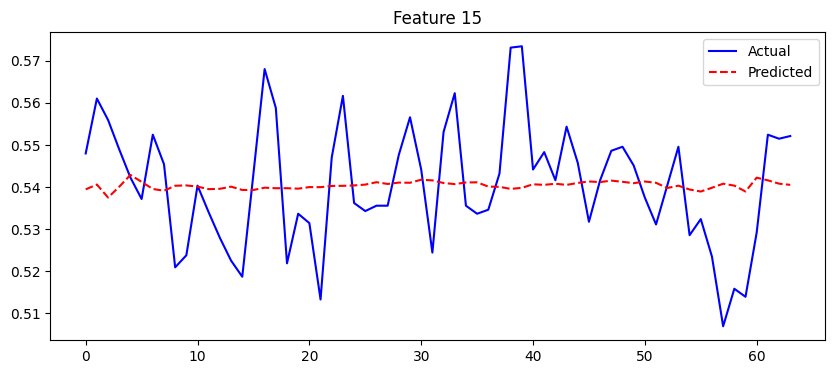

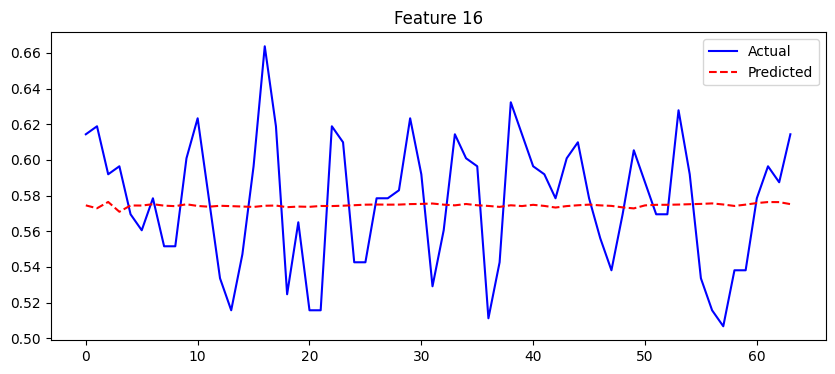

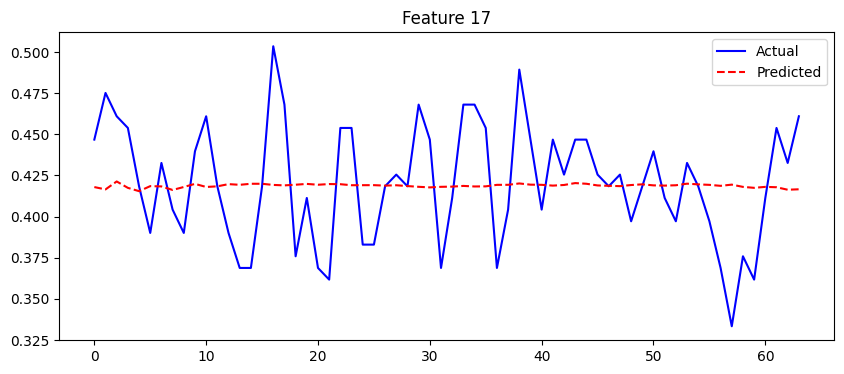

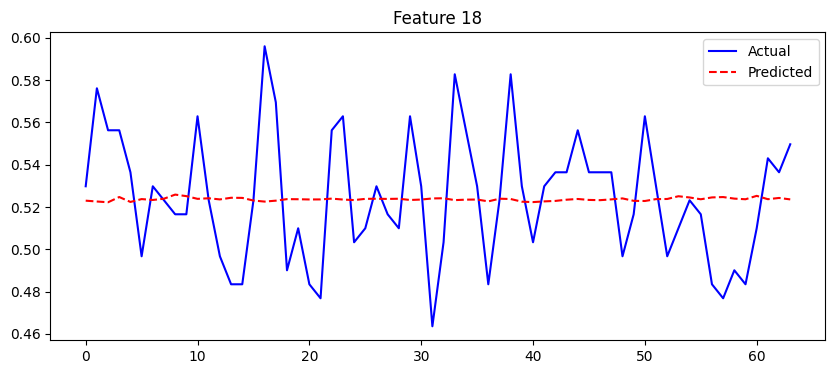

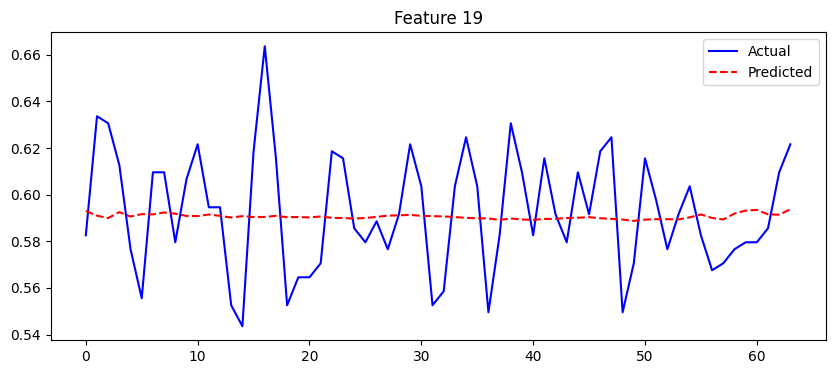

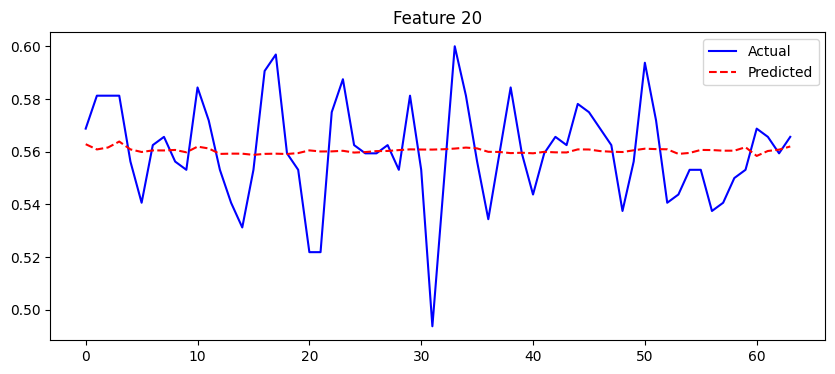

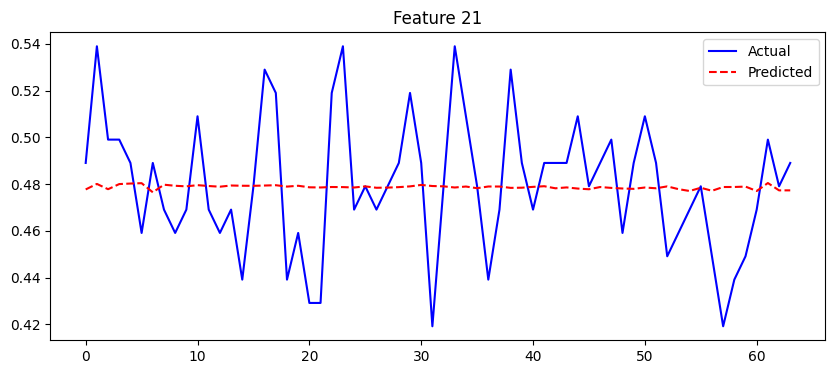

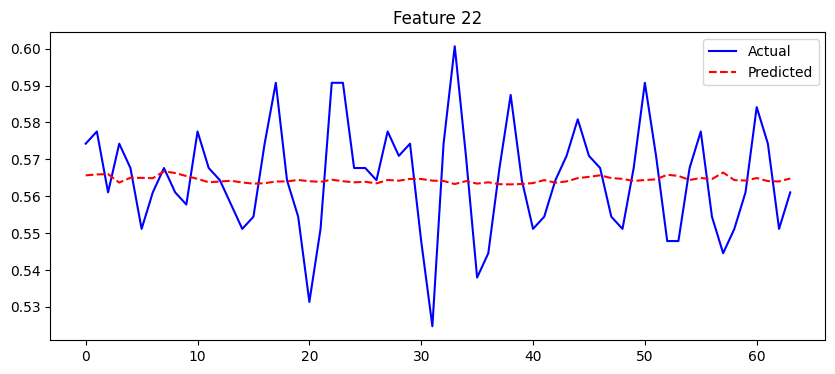

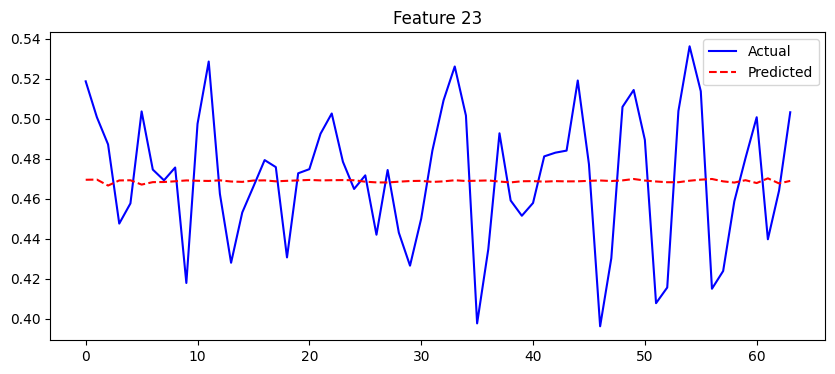

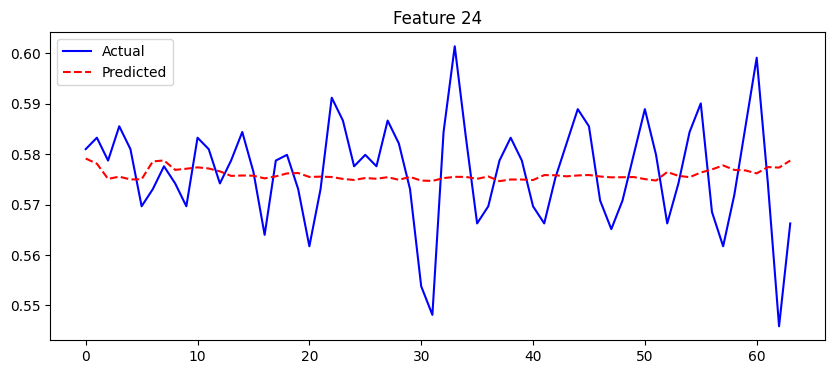

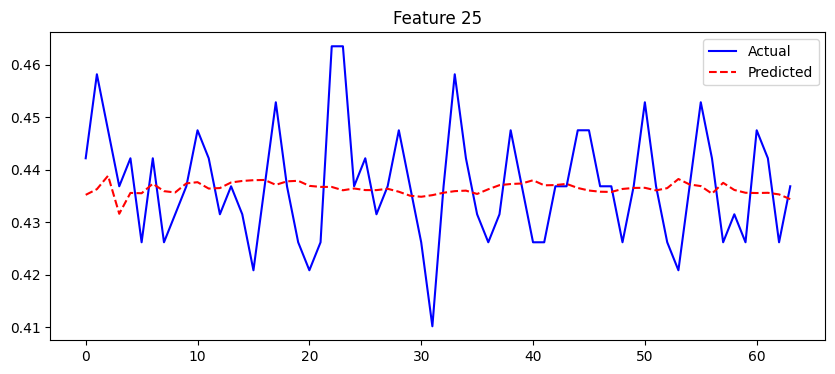

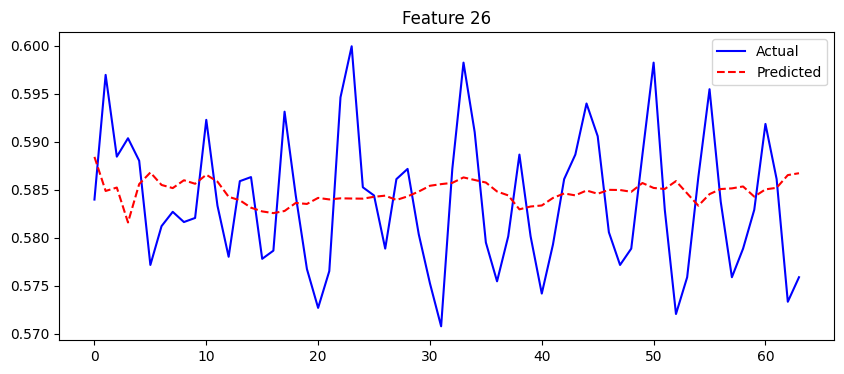

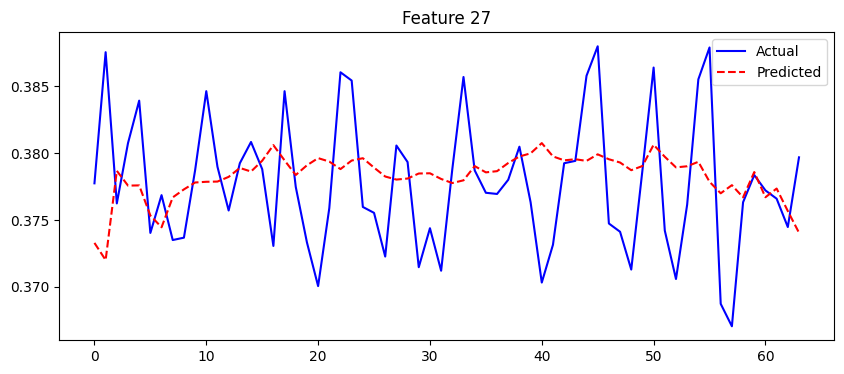

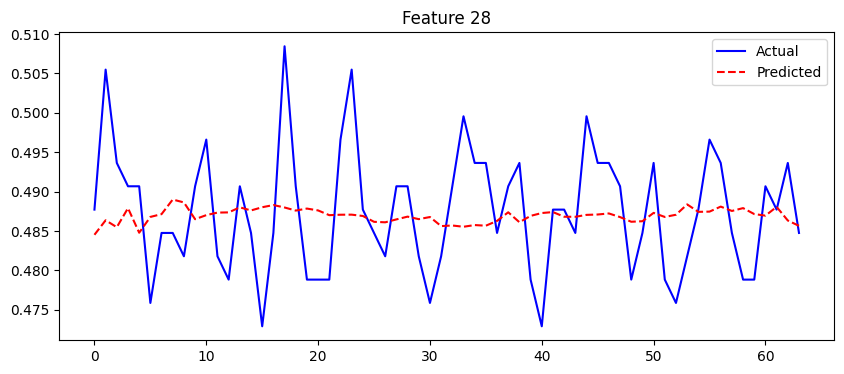

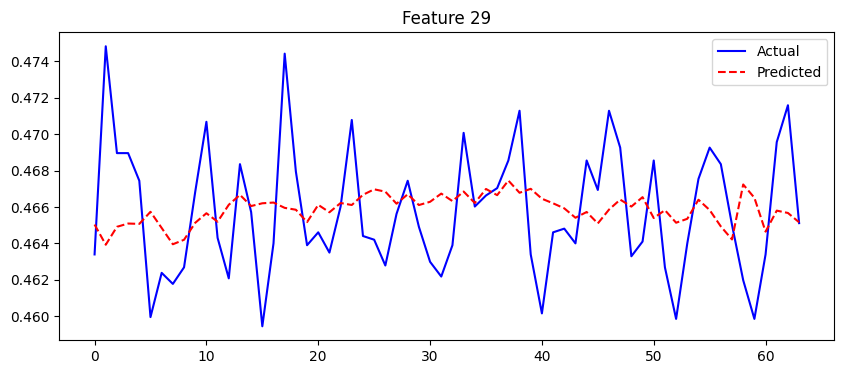

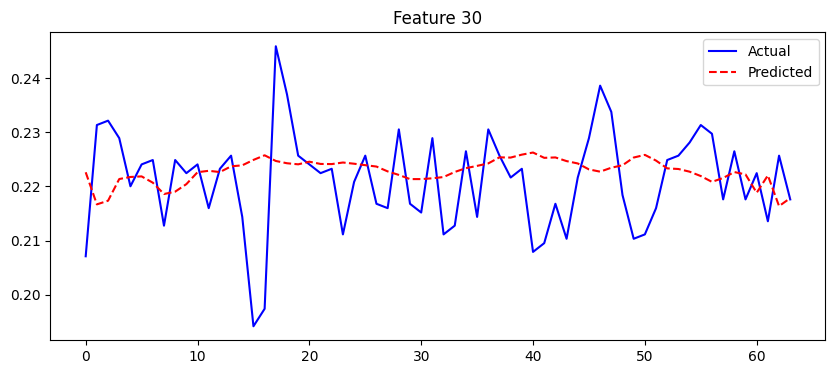

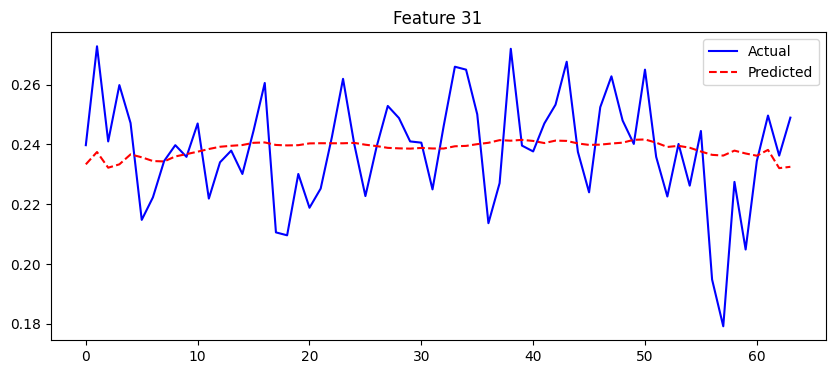

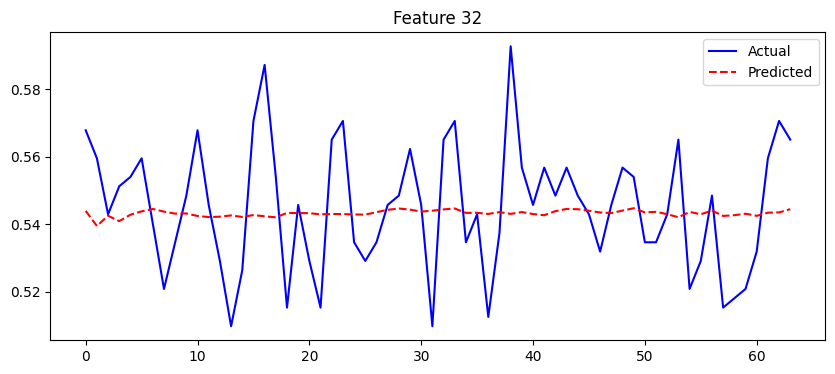

In [31]:
import matplotlib.pyplot as plt


def plot_feature_comparisons(original, prediction, feature_index, num_samples=eeg_inputs.shape[1]):
    # Plot actual vs predicted for a single feature up to num_samples data points
    plt.figure(figsize=(10, 4))
    plt.plot(original[:num_samples], 'b-', label='Actual')
    plt.plot(prediction[:num_samples], 'r--', label='Predicted')
    plt.title(f'Feature {feature_index + 1}')
#     plt.ylim(0,1)
    plt.legend()
    plt.show()

# Extract only one batch from the test dataset
for (eeg_inputs, conditions), _ in test_dataset.take(1):
    # Assuming the eeg_inputs shape is (batch_size, 64, 32), where 64 is temporal steps and 32 is features
    # Let's take the first sample of the batch
    first_sample_input = eeg_inputs[0]  # Shape (64, 32)
    first_sample_condition = conditions[0:1]  # Shape (1, 1) since we take one sample
    print(f'Condition is {first_sample_condition}')


    # Predict the output using the cvae model
    predicted_output = cvae.predict([first_sample_input[tf.newaxis, ...], first_sample_condition])
    # tf.newaxis is used to add a batch dimension for prediction, resulting in shape (1, 64, 32)

    # Squeeze to remove the batch dimension from the predicted output, so we can compare it directly
    predicted_output = predicted_output.squeeze()  # Shape (64, 32)

    # Now plot the actual vs predicted for the first three features
    for i in range(32):
        actual = first_sample_input[:, i].numpy()  # Take all 64 temporal steps for the i-th feature
        predicted = predicted_output[:, i]  # Take all 64 temporal steps for the i-th feature in the predicted output
        plot_feature_comparisons(actual, predicted, feature_index=i)


In [32]:
from sklearn.ensemble import RandomForestClassifier
# Function to extract latent representations and conditions from a dataset
def extract_latent_and_conditions(dataset, encoder):
    latent_representations = []
    conditions = []
    i = 0
    for (eeg_inputs, condition_labels), _ in dataset:
        mean, _, _ = encoder.predict([eeg_inputs, condition_labels])
        if i < 3:
            print(f'shape of mean vector is {mean.shape}')
        i += 1
        latent_representations.append(mean)
        conditions.append(condition_labels.numpy())
    latent_representations = np.concatenate(latent_representations, axis=0)
    conditions = np.concatenate(conditions, axis=0).flatten()
    return latent_representations, conditions

# Extract latent representations and conditions for training
train_latent, train_conditions = extract_latent_and_conditions(train_dataset, encoder)

# Train the classifier with the training dataset
classifier = RandomForestClassifier()
classifier.fit(train_latent, train_conditions)

# Extract latent representations and conditions for testing
test_latent, test_conditions = extract_latent_and_conditions(test_dataset, encoder)

# Predict the conditions using the test dataset latent representations
predicted_conditions = classifier.predict(test_latent)

# Evaluate the classifier performance
from sklearn.metrics import accuracy_score, classification_report

test_accuracy = accuracy_score(test_conditions, predicted_conditions)
print(f"Test accuracy: {test_accuracy}")
print(classification_report(test_conditions, predicted_conditions))


1/1 [==============================] - 0s 116ms/step
shape of mean vector is (32, 32)
1/1 [==============================] - 0s 18ms/step
shape of mean vector is (32, 32)
1/1 [==============================] - 0s 17ms/step
shape of mean vector is (32, 32)
1/1 [==============================] - 0s 18ms/step
shape of mean vector is (32, 32)
1/1 [==============================] - 0s 18ms/step
shape of mean vector is (32, 32)
1/1 [==============================] - 0s 28ms/step
shape of mean vector is (32, 32)
1/1 [==============================] - 0s 19ms/step
Test accuracy: 0.9220328282828283
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1621
           1       0.89      0.96      0.92      1547

    accuracy                           0.92      3168
   macro avg       0.92      0.92      0.92      3168
weighted avg       0.92      0.92      0.92      3168



Test accuracy using xgb classifier on test data is: 0.9488636363636364
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1621
           1       0.94      0.96      0.95      1547

    accuracy                           0.95      3168
   macro avg       0.95      0.95      0.95      3168
weighted avg       0.95      0.95      0.95      3168



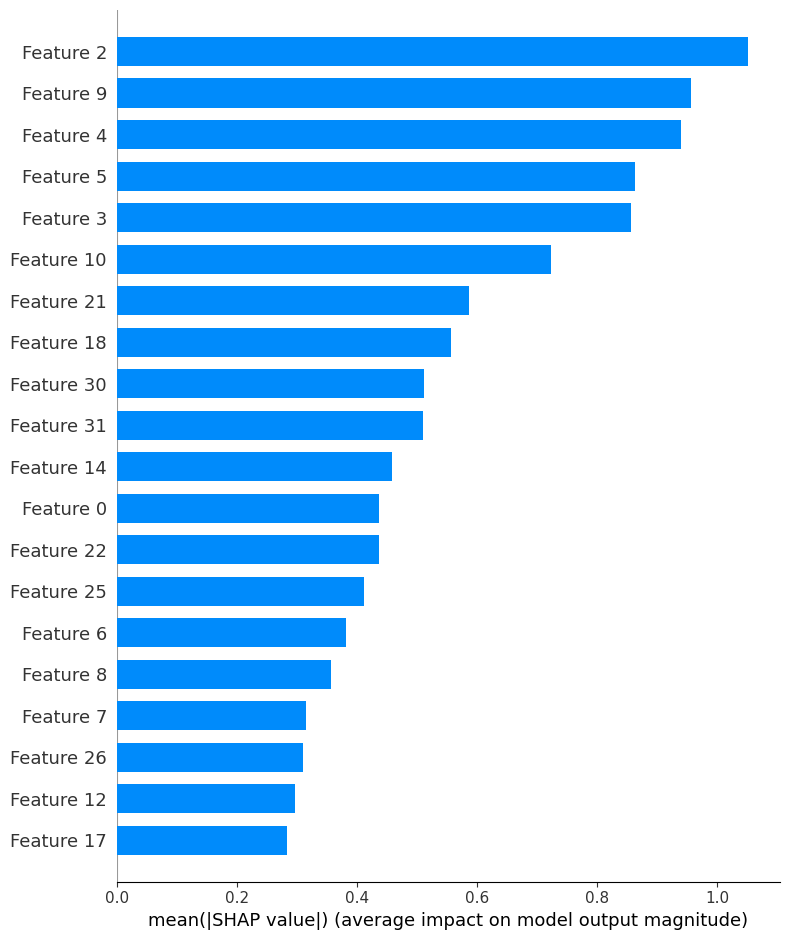

In [42]:
import xgboost as xgb
import shap

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(train_latent, train_conditions)
predicted_conditions_xgb = xgb_clf.predict(test_latent)
test_accuracy_xgb = accuracy_score(test_conditions, predicted_conditions_xgb)
print(f"Test accuracy using xgb classifier on test data is: {test_accuracy_xgb}")
print(classification_report(test_conditions, predicted_conditions_xgb))
# Compute SHAP values
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(train_latent)

# Summary plot of SHAP values
shap.summary_plot(shap_values, train_latent, plot_type="bar")


In [38]:
from sklearn.linear_model import LogisticRegression
# classifier with the training dataset
classifier = LogisticRegression()
classifier.fit(train_latent, train_conditions)

predicted_conditions = classifier.predict(test_latent)

from sklearn.metrics import accuracy_score, classification_report

test_accuracy = accuracy_score(test_conditions, predicted_conditions)
print(f"Test accuracy with linear classifier without pca is : {test_accuracy}")
print(classification_report(test_conditions, predicted_conditions))


Test accuracy with linear classifier without pca is : 0.8093434343434344
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1621
           1       0.73      0.96      0.83      1547

    accuracy                           0.81      3168
   macro avg       0.84      0.81      0.81      3168
weighted avg       0.84      0.81      0.81      3168



In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
pca = PCA(n_components=2)
train_latent_pca = pca.fit_transform(train_latent)
test_latent_pca = pca.transform(test_latent)

# tsne = TSNE(n_components=2)
# train_latent_tsne = tsne.fit_transform(train_latent)
# test_latent_tsne = tsne.transform(test_latent)

# Train classifiers on PCA-reduced data
# classifierLog_pca = LogisticRegression()
# classifierLog_pca.fit(train_latent_pca, train_conditions)
# predicted_conditions_pca = classifierLog_pca.predict(test_latent_pca)
# print(f"PCA - Logistic Regression Test accuracy: {accuracy_score(test_conditions, predicted_conditions_pca)}")
# print(classification_report(test_conditions, predicted_conditions_pca))

classifierLog_pca = LogisticRegression()
classifierLog_pca.fit(train_latent_pca, train_conditions)
predicted_conditions_pca = classifierLog_pca.predict(test_latent_pca)
print(f"PCA - Logistic Regression Test accuracy: {accuracy_score(test_conditions, predicted_conditions_pca)}")
print(classification_report(test_conditions, predicted_conditions_pca))

classifierRandomForest_pca = RandomForestClassifier()
classifierRandomForest_pca.fit(train_latent_pca, train_conditions)
predicted_conditions_Forest_pca = classifierRandomForest_pca.predict(test_latent_pca)
print(f"PCA - Random Forest Test accuracy: {accuracy_score(test_conditions, predicted_conditions_Forest_pca)}")
print(classification_report(test_conditions, predicted_conditions_Forest_pca))

classifierSVM_pca = SVC(kernel='rbf', probability=True)
classifierSVM_pca.fit(train_latent_pca, train_conditions)
predicted_conditions_svm_pca = classifierSVM_pca.predict(test_latent_pca)
print(f"PCA - SVM Test accuracy: {accuracy_score(test_conditions, predicted_conditions_svm_pca)}")
print(classification_report(test_conditions, predicted_conditions_svm_pca))

classifierTree_pca = DecisionTreeClassifier()
classifierTree_pca.fit(train_latent_pca, train_conditions)
predicted_conditions_tree_pca = classifierTree_pca.predict(test_latent_pca)
print(f"PCA - Decision Tree Test accuracy: {accuracy_score(test_conditions, predicted_conditions_tree_pca)}")
print(classification_report(test_conditions, predicted_conditions_tree_pca))



# Repeat for t-SNE and UMAP reduced data (example for t-SNE)
# classifierLog_tsne = LogisticRegression()
# classifierLog_tsne.fit(train_latent_tsne, train_conditions)
# predicted_conditions_tsne = classifierLog_tsne.predict(test_latent_tsne)
# print(f"t-SNE - Logistic Regression Test accuracy: {accuracy_score(test_conditions, predicted_conditions_tsne)}")
# print(classification_report(test_conditions, predicted_conditions_tsne))


# classifierSVM_tsne = SVC(kernel='rbf', probability=True)
# classifierSVM_tsne.fit(train_latent_tsne, train_conditions)
# predicted_conditions_svm_tsne = classifierSVM_pca.predict(test_latent_tsne)
# print(f"T-sne - SVM Test accuracy: {accuracy_score(test_conditions, predicted_conditions_svm_tsne)}")
# print(classification_report(test_conditions, predicted_conditions_svm_tsne))

# classifierTree_tsne = DecisionTreeClassifier()
# classifierTree_tsne.fit(train_latent_tsne, train_conditions)
# predicted_conditions_tree_tsne = classifierTree_tsne.predict(test_latent_tsne)
# print(f"tsne - Decision Tree Test accuracy: {accuracy_score(test_conditions, predicted_conditions_tree_tsne)}")
# print(classification_report(test_conditions, predicted_conditions_tree_tsne))

PCA - Logistic Regression Test accuracy: 0.7395833333333334
              precision    recall  f1-score   support

           0       0.89      0.56      0.69      1621
           1       0.67      0.93      0.78      1547

    accuracy                           0.74      3168
   macro avg       0.78      0.74      0.73      3168
weighted avg       0.78      0.74      0.73      3168

PCA - Random Forest Test accuracy: 0.819760101010101
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1621
           1       0.81      0.82      0.82      1547

    accuracy                           0.82      3168
   macro avg       0.82      0.82      0.82      3168
weighted avg       0.82      0.82      0.82      3168

PCA - SVM Test accuracy: 0.8323863636363636
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1621
           1       0.83      0.83      0.83      1547

    accuracy             

In [34]:
import plotly.express as px
import plotly.graph_objects as go

def plot_decision_boundary_plotly(X, y, model, title):
    h = .005  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.001, X[:, 0].max() + 0.001
    y_min, y_max = X[:, 1].min() - 0.001, X[:, 1].max() + 0.001
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y, labels={'x': 'Principal Component 1', 'y': 'Principal Component 2'})
    fig.update_traces(marker=dict(size=5))
    # fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, opacity=0.5, colorscale='RdBu', name='Decision Boundary'))
    fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, opacity=0.5, name='Decision Boundary'))
    fig.update_layout(title=title)
    fig.show()

# Plot the decision boundary using the PCA-reduced training data
plot_decision_boundary_plotly(train_latent_pca, train_conditions, classifierSVM_pca, 'PCA - SVM Decision Boundary')

In [36]:
# Train classifiers on PCA-reduced data
classifierLog_pca = LogisticRegression()
classifierLog_pca.fit(train_latent_pca, train_conditions)
predicted_conditions_pca = classifierLog_pca.predict(test_latent_pca)
print(f"PCA - Logistic Regression Test accuracy: {accuracy_score(test_conditions, predicted_conditions_pca)}")
print(classification_report(test_conditions, predicted_conditions_pca))

PCA - Logistic Regression Test accuracy: 0.7389520202020202
              precision    recall  f1-score   support

           0       0.89      0.56      0.69      1621
           1       0.67      0.93      0.78      1547

    accuracy                           0.74      3168
   macro avg       0.78      0.74      0.73      3168
weighted avg       0.78      0.74      0.73      3168



In [43]:
import plotly.express as px
import plotly.graph_objects as go

def plot_decision_boundary_plotly(X, y, model, title):
    h = .005  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.001, X[:, 0].max() + 0.001
    y_min, y_max = X[:, 1].min() - 0.001, X[:, 1].max() + 0.001
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y, labels={'x': 'Principal Component 1', 'y': 'Principal Component 2'})
    fig.update_traces(marker=dict(size=5))
    # fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, opacity=0.5, colorscale='RdBu', name='Decision Boundary'))
    fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, opacity=0.5, name='Decision Boundary'))
    fig.update_layout(title=title)
    fig.show()

# Plot the decision boundary using the PCA-reduced training data
plot_decision_boundary_plotly(train_latent_pca, train_conditions, classifierLog_pca, 'PCA - Logistic Decision Boundary')

In [45]:

classifierXGB_pca = xgb.XGBClassifier()
classifierXGB_pca.fit(train_latent_pca, train_conditions)
predicted_conditions_XGB_pca = classifierXGB_pca.predict(test_latent_pca)
print(f"PCA - XGB Test accuracy: {accuracy_score(test_conditions, predicted_conditions_XGB_pca)}")
print(classification_report(test_conditions, predicted_conditions_XGB_pca))

def plot_decision_boundary_plotly(X, y, model, title):
    h = .005  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.001, X[:, 0].max() + 0.001
    y_min, y_max = X[:, 1].min() - 0.001, X[:, 1].max() + 0.001
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    fig = px.scatter(x=X[:, 0], y=X[:, 1], color=y, labels={'x': 'Principal Component 1', 'y': 'Principal Component 2'})
    fig.update_traces(marker=dict(size=5))
    # fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, opacity=0.5, colorscale='RdBu', name='Decision Boundary'))
    fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, opacity=0.5, name='Decision Boundary'))
    fig.update_layout(title=title)
    fig.show()


plot_decision_boundary_plotly(train_latent_pca, train_conditions, classifierXGB_pca, 'PCA - XGB train Decision Boundary')


PCA - XGB Test accuracy: 0.8295454545454546
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1621
           1       0.83      0.82      0.82      1547

    accuracy                           0.83      3168
   macro avg       0.83      0.83      0.83      3168
weighted avg       0.83      0.83      0.83      3168



# Finish